In [1]:
# Jupyter Notebook to calibrate the pixel size of a map reconstruction using an atomic model 

import os
import numpy as np
import matplotlib.pyplot as plt

import gemmi 
import emmer
from emmer.pdb.convert.convert_pdb_to_map import convert_pdb_to_map
from emmer.pdb.pdb_utils import set_atomic_bfactors
from emmer.ndimage.mask.get_atomic_model_mask import get_atomic_model_mask
from emmer.ndimage.average_half_maps import average_half_maps
from emmer.ndimage.compute_real_space_correlation import compute_real_space_correlation 
from emmer.ndimage.fsc.calculate_fsc_curve import calculate_fsc_curve
from emmer.ndimage.filter.low_pass_filter import low_pass_filter
from emmer.ndimage.map_utils import load_map

In [2]:
pdb_path = "/home/abharadwaj1/dev/map_sharpening/tests/calibrate_pixels/7rrp_on_P17_J82_012.pdb"
halfmap_1_path = "/home/abharadwaj1/dev/map_sharpening/tests/calibrate_pixels/cryosparc_P17_J82_012_volume_map_half_A.mrc"
halfmap_2_path = "/home/abharadwaj1/dev/map_sharpening/tests/calibrate_pixels/cryosparc_P17_J82_012_volume_map_half_B.mrc"

# Display original apix value 
halfmap1, apix_original = load_map(halfmap_1_path)
unitcell = np.array(halfmap1.shape) * apix_original

print("Original properties of the map:")
print(f"Apix: {apix_original}")
print(f"Unitcell: {unitcell}")
print(f"Shape: {halfmap1.shape}")




Original properties of the map:
Apix: 0.733400026957194
Unitcell: [264.0240097 264.0240097 264.0240097]
Shape: (360, 360, 360)


In [3]:
unsharpened_map = average_half_maps(halfmap_1_path, halfmap_2_path, output_filename=None, return_map=True)
input_shape = unsharpened_map.shape



In [4]:
# Pixel size should be large enough such that the atomic model can be seen in the map
# If the pixel size is too small, the atomic model will not be visible in the map and gives an error while simulating the map
# Calculate the minimum pixel size by knowing the size of the protein (in Angstrom) and dividing it by the size of the map (in pixels) 
# The pixel size range should be more than the minimum pixel size calculated above
pixel_size_range = np.arange(0.69, 0.77, step=0.01)


In [5]:
rscc_values_unmasked = []
rscc_values_masked = []

fsc_curves_unmasked = []
fsc_curves_masked = []

fsc_average_unmasked = []
fsc_average_masked = []

In [6]:
# from tqdm import tqdm 
# for apix in tqdm(pixel_size_range): 
#     # set atomic b-factors to 0
#     st = set_atomic_bfactors(input_pdb=pdb_path, b_iso=0)

#     # convert pdb to map 
#     model_map = convert_pdb_to_map(input_pdb=st, size=input_shape, apix=apix, verbose=False)
#     ## low pass filter the map 
#     # model_map = low_pass_filter(model_map, cutoff=4, apix=apix)
#     # get atomic model mask
#     model_mask = get_atomic_model_mask(unsharpened_map, apix, st, dilation_radius=3.5)
    
#     # Perform calculations 

#     rscc = compute_real_space_correlation(model_map, unsharpened_map)
#     fsc = calculate_fsc_curve(model_map, unsharpened_map) 
#     fsc_average = np.mean(fsc)

#     masked_model_map = model_map * model_mask
#     masked_unsharpened_map = unsharpened_map * model_mask

#     masked_rscc = compute_real_space_correlation(masked_model_map, masked_unsharpened_map)
#     masked_fsc = calculate_fsc_curve(masked_model_map, masked_unsharpened_map)
#     masked_fsc_average = np.mean(masked_fsc)

#     # Combine all results 

#     rscc_values_unmasked.append(rscc)
#     rscc_values_masked.append(masked_rscc)

#     fsc_curves_unmasked.append(fsc)
#     fsc_curves_masked.append(masked_fsc)

#     fsc_average_unmasked.append(fsc_average)
#     fsc_average_masked.append(masked_fsc_average)


In [7]:
from joblib import Parallel, delayed
from tqdm import tqdm
import numpy as np

def process_apix(apix, pdb_path, input_shape, unsharpened_map):
    # Set atomic b-factors to 0
    st = set_atomic_bfactors(input_pdb=pdb_path, b_iso=0)

    # Convert pdb to map 
    model_map = convert_pdb_to_map(input_pdb=st, size=input_shape, apix=apix, verbose=False)

    # Get atomic model mask
    model_mask = get_atomic_model_mask(unsharpened_map, apix, st, dilation_radius=3.5)
    
    # Perform calculations 
    rscc = compute_real_space_correlation(model_map, unsharpened_map)
    fsc = calculate_fsc_curve(model_map, unsharpened_map) 
    fsc_average = np.mean(fsc)

    masked_model_map = model_map * model_mask
    masked_unsharpened_map = unsharpened_map * model_mask

    masked_rscc = compute_real_space_correlation(masked_model_map, masked_unsharpened_map)
    masked_fsc = calculate_fsc_curve(masked_model_map, masked_unsharpened_map)
    masked_fsc_average = np.mean(masked_fsc)

    return {
        'rscc_unmasked': rscc,
        'rscc_masked': masked_rscc,
        'fsc_unmasked': fsc,
        'fsc_masked': masked_fsc,
        'fsc_average_unmasked': fsc_average,
        'fsc_average_masked': masked_fsc_average
    }




100%|██████████| 9/9 [00:00<00:00, 480.09it/s]


In [ ]:

n_jobs = len(pixel_size_range)
# Parallel execution
results = Parallel(n_jobs=n_jobs)(delayed(process_apix)(apix, pdb_path, input_shape, unsharpened_map) for apix in tqdm(pixel_size_range))

# Post-processing to collect results
rscc_values_unmasked = [result['rscc_unmasked'] for result in results]
rscc_values_masked = [result['rscc_masked'] for result in results]
fsc_curves_unmasked = [result['fsc_unmasked'] for result in results]
fsc_curves_masked = [result['fsc_masked'] for result in results]
fsc_average_unmasked = [result['fsc_average_unmasked'] for result in results]
fsc_average_masked = [result['fsc_average_masked'] for result in results]

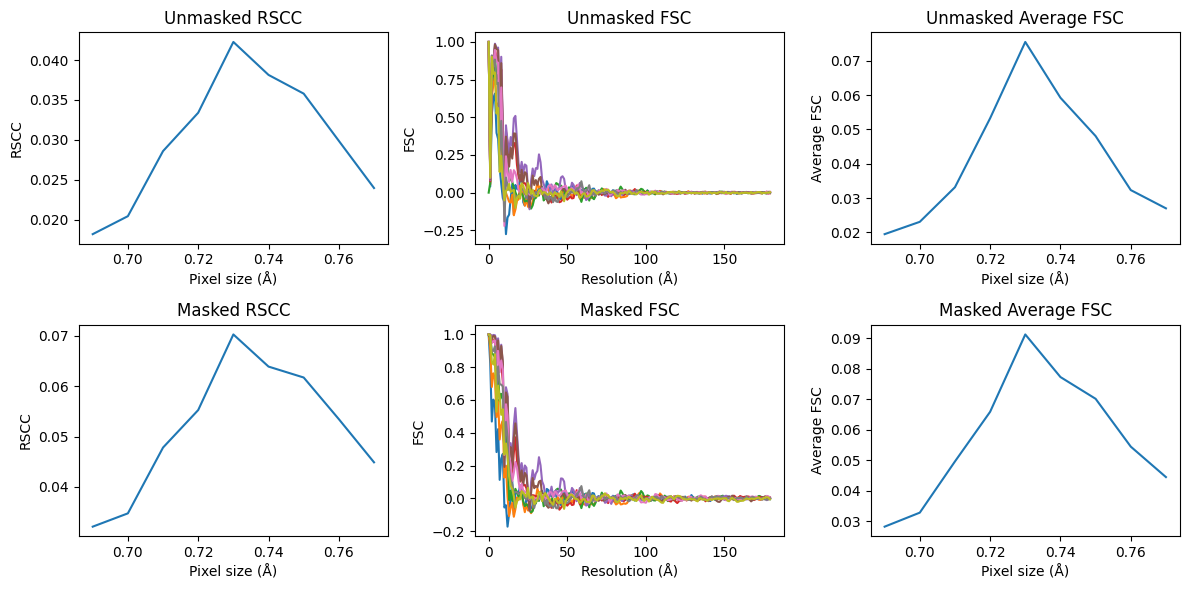

In [8]:


fig, ax = plt.subplots(2, 3, figsize=(12, 6))

# plot unmasked values in top row and masked values in bottom row
# plot rscc values
ax[0, 0].plot(pixel_size_range, rscc_values_unmasked, label="Unmasked")
ax[0, 0].set_xlabel("Pixel size (Å)")
ax[0, 0].set_ylabel("RSCC")
ax[0, 0].set_title("Unmasked RSCC")

ax[1, 0].plot(pixel_size_range, rscc_values_masked, label="Masked")
ax[1, 0].set_xlabel("Pixel size (Å)")
ax[1, 0].set_ylabel("RSCC")
ax[1, 0].set_title("Masked RSCC")

# plot fsc curves
for i, fsc_curve in enumerate(fsc_curves_unmasked):
    ax[0, 1].plot(fsc_curve, label=f"apix={pixel_size_range[i]}")

ax[0, 1].set_xlabel("Resolution (Å)")
ax[0, 1].set_ylabel("FSC")
ax[0, 1].set_title("Unmasked FSC")
#ax[0, 1].legend()   
# 
for i, fsc_curve in enumerate(fsc_curves_masked):
    ax[1, 1].plot(fsc_curve, label=f"apix={pixel_size_range[i]}")

ax[1, 1].set_xlabel("Resolution (Å)")
ax[1, 1].set_ylabel("FSC")
ax[1, 1].set_title("Masked FSC")
#ax[1, 1].legend()

# plot fsc averages
ax[0, 2].plot(pixel_size_range, fsc_average_unmasked, label="Unmasked")
ax[0, 2].set_xlabel("Pixel size (Å)")
ax[0, 2].set_ylabel("Average FSC")
ax[0, 2].set_title("Unmasked Average FSC")


ax[1, 2].plot(pixel_size_range, fsc_average_masked, label="Masked")
ax[1, 2].set_xlabel("Pixel size (Å)")
ax[1, 2].set_ylabel("Average FSC")
ax[1, 2].set_title("Masked Average FSC")

plt.tight_layout()
plt.show()



